## **Finding origin of replication and DnaA boxes**

In most bacteria and some Archaea, leading strand contains more guanine whereas the lagging strand contains more cytosine (Lobry, 1996), due to the asymmetric nature of the replication process whick causes more mutations in one strand as compared to the other (Tillier and Collins, 2000). Deamination of cytosine and ultimately mutation of cytosine to thymine in one DNA strand can increase the relative number of guanine and thymine to cytosine and adenine.

That's the reason why the difference between G and C content (G - C) is positive in the leading strand and negative in the lagging strand, so it is expected to see a switch in this difference sign just at the point of DNA replication origin and terminus. So we can take profit of this to find where are these origin and terminus of replication of a given bacteria genome.

First, we import all required libraries and packages:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from selenium import webdriver
import time

Now we import the FASTA sequence from the NCBI url. For example, we'll use Salmonella enterica genome from https://www.ncbi.nlm.nih.gov/nuccore/AL513382.1?report=fasta:

In [3]:
url='https://www.ncbi.nlm.nih.gov/nuccore/AL513382.1?report=fasta'

def importFastaSeq(url):
    search_string=''
    
    options = webdriver.ChromeOptions()
    options.add_argument('--ignore-certificate-errors')
    options.add_argument("--start-minimized")


    driver = webdriver.Chrome(options=options)
    driver.delete_all_cookies()
    driver.get(url)
    time.sleep(30)
    fastaSeq=driver.find_element_by_xpath('//*[@id="viewercontent1"]').text
    fastaSeq=''.join(fastaSeq.split('\n')[1:])
    driver.close()
    return fastaSeq

sequence=importFastaSeq(url=url)

We plot cumulative GC differences to see if there's a switch and which is the position with this difference is minimum:

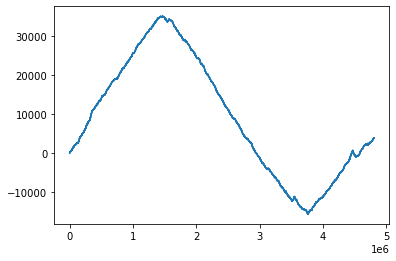

Position with minimum difference between number of G and number of C is 3764856


In [4]:
def plottingGCdiffs(sequence):
    numC=0
    numG=0
    diffsGC=[]=[]
    minDiff=100000
    posMinDiff=0
    for i in np.arange(len(sequence)-1):
        if sequence[i]=='C':
            numC+=1
        elif sequence[i]=='G':
            numG+=1
        diffGC=numG-numC
        diffsGC.append(diffGC)
        if diffGC<minDiff:
            minDiff=diffGC
            posMinDiff=i+1
    
    plt.plot(diffsGC)
    plt.show()
    
    return minDiff,posMinDiff

minDiff, posMinDiff = plottingGCdiffs(sequence=sequence)
print('Position with minimum difference between number of G and number of C is {}'.format(posMinDiff))

### Finding DnaA boxes

DNA replication in bacteria is activated with binding of DnaA protein to 9-mer (9-bp) repeats upstream of oriC or DnaA boxes. Once we have estimated oriC position, we can search repeat 9-mers surrounding this area (including reverse complement and mismatches caused by mutations which don't affect DnaA protein binding):

In [26]:
windowSize=500
kmerSize=9
kmers=[]

oriCsequence=sequence[int(posMinDiff-windowSize/2):int(posMinDiff+1+windowSize/2)]
reversedComplementSequence=''
for nuc in oriCsequence[::-1]:
    if nuc=='A':
        reversedComplementSequence+='T'
    elif nuc=='T':
        reversedComplementSequence+='A'
    elif nuc=='C':
        reversedComplementSequence+='G'
    elif nuc=='G':
        reversedComplementSequence+='C'

for i in np.arange(len(oriCsequence)):
    kmer=oriCsequence[i:i+kmerSize]
    kmers.append(kmer)
    kmer=reversedComplementSequence[i:i+kmerSize]
    kmers.append(kmer)
    
def kmersWithMismatchesDict(kmers,kmerSize,maxNumMismatchesAllowed):
    kmersUnique=list(set(kmers))
    dictKmersWithMismatches={}
    for kmer in kmersUnique:
        dictKmersWithMismatches[kmer]=[]  
    for kmer1 in kmersUnique:
        for kmer2 in kmers:  
            if len(kmer1)==kmerSize and len(kmer2)==kmerSize:
                count=0
                for i in np.arange(kmerSize):

                    if kmer1[i]!=kmer2[i]:
                        count+=1
                if count<=maxNumMismatchesAllowed:
                    dictKmersWithMismatches[kmer1].append(kmer2)
    return dictKmersWithMismatches

#Allowing 1 mismatch:
kmersWithMismatches=(kmersWithMismatchesDict(kmers,9,1))

def mostFreqKmerWithMismatches(dictKmers):
    mostFreqKmers={}
    casesMostFreqKmer=0
    for kmer,cases in dictKmers.items():
        cases=len(cases)-1
        if cases>casesMostFreqKmer:
            mostFreqKmers={}
            mostFreqKmers[kmer]=dictKmers[kmer]
            casesMostFreqKmer=cases
        if cases==casesMostFreqKmer:
            mostFreqKmers[kmer]=dictKmers[kmer]
            casesMostFreqKmer=cases
    return mostFreqKmers

DnaAboxes=list(mostFreqKmerWithMismatches(kmersWithMismatches).keys())
print(DnaAboxes)

['GCGGCGCCG', 'CCGGCGCCG', 'CGGCGCCGA', 'TTCCGGAAT', 'ACGGCGCCG', 'TCGGCGCCG', 'CGGCGCCGG', 'ATTCCGGAA', 'CGGCGCCGT', 'CGGCGCCGC']


So this list of 9-mers can be DnaA boxes in Salmonella enterica genome. Obviously this has to be experimentally confirmed. 